In [1]:
from dataset_functions import from_path_to_dataloader
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
#plot   
import matplotlib.pyplot as plt

c:\Users\lucat\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#create the dataloaders
path_train = './chaoyang-data/train'
path_test = './chaoyang-data/test'
batch_size = 32

train_dataloader = from_path_to_dataloader(path_train, batch_size, True, True)
test_dataloader = from_path_to_dataloader(path_test, batch_size, False, False)

#split the train dataset into train and validation
train_size = int(0.8 * len(train_dataloader.dataset))
val_size = len(train_dataloader.dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataloader.dataset, [train_size, val_size])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#use the GPU if available

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#use huggingface's pretrained model for image classification vit-base-patch16-224
model = transformers.ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=1000)
# use huggingface's pretrained model for image classification swin-base-patch4-window7-224
#model = transformers.Swinv2Model.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")
# change the number of output classes to 4
#model.classifier = nn.Linear(1024, 4)
model.classifier = nn.Linear(768, 4)
model.to(device)
#use the AdamW optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
#use the cross entropy loss
criterion = nn.CrossEntropyLoss()


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
from tqdm import tqdm
#import classification_report from sklearn
from sklearn.metrics import classification_report
def evaluate(model, val_dataloader, criterion):
    #initialize the loss and the number of correct predictions
    val_loss = 0
    correct = 0
    predictions=[]
    labels=[]
    #for each batch
    with torch.no_grad():
        for data, target in tqdm(val_dataloader):
            #send the data and the target to the GPU
            data, target = data.to(device), target.to(device)
            #forward pass
            output = model(data)
            #compute the loss
            val_loss += criterion(output.logits, target).item()
            #compute the number of correct predictions
            pred = output.logits.argmax(dim=1, keepdim=True)
            #append the predictions
            predictions.extend(pred.cpu().numpy().tolist())
            #append the labels
            labels.extend(target.cpu().numpy().tolist())

    #compute the average loss
    val_loss /= len(val_dataloader.dataset)
    #return the average loss and the number of correct predictions
    #print the classification report
    print(classification_report(labels, predictions))
    return val_loss, correct

In [4]:

#train the model
output_path = './models/'
def train(model, train_dataloader, val_dataloader, optimizer, criterion, epochs):
    #set the model in training mode
    model.train()
    train_losses = []
    val_losses = []
    #for each epoch
    for epoch in range(epochs):
        train_losses_inner = []
        loss=0
        #for each batch
        for (data, target) in tqdm(train_dataloader):
            #send the data and the target to the GPU
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output.logits, target)
            train_losses_inner.append(loss.cpu().detach().numpy())
            loss += loss.item()
            loss.backward()
            optimizer.step()
        train_losses.append(np.mean(train_losses_inner))
        #evaluate the model on the validation set
        print('Epoch: ', epoch)
        print('Validation set:')
        val_loss, val_accuracy = evaluate(model, val_dataloader, criterion)
        val_losses.append(val_loss)
        print('Test set:')
        test_loss, test_accuracy = evaluate(model, test_dataloader, criterion)
        #if the path doesn't exist, create it
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        #save the model
        torch.save(model.state_dict(), output_path + 'model_' + str(epoch) + '.pth')
    #plot the train and validation losses after transferring to cpu
    

    print(train_losses)
    plt.plot(train_losses, label='train loss')
    plt.plot(val_losses, label='validation loss')
    plt.legend()
    plt.show()
    

        

100%|██████████| 141/141 [02:18<00:00,  1.02it/s]


Epoch:  0
Validation set:


100%|██████████| 36/36 [00:25<00:00,  1.39it/s]


              precision    recall  f1-score   support

           0       0.67      0.75      0.71       283
           1       0.53      0.35      0.42       297
           2       0.77      0.95      0.85       272
           3       0.66      0.67      0.66       272

    accuracy                           0.67      1124
   macro avg       0.66      0.68      0.66      1124
weighted avg       0.66      0.67      0.66      1124

Test set:


100%|██████████| 67/67 [01:06<00:00,  1.01it/s]


              precision    recall  f1-score   support

           0       0.80      0.68      0.73       705
           1       0.40      0.35      0.37       321
           2       0.84      0.98      0.90       840
           3       0.69      0.72      0.70       273

    accuracy                           0.75      2139
   macro avg       0.68      0.68      0.68      2139
weighted avg       0.74      0.75      0.74      2139



100%|██████████| 141/141 [01:24<00:00,  1.67it/s]


Epoch:  1
Validation set:


100%|██████████| 36/36 [00:15<00:00,  2.30it/s]


              precision    recall  f1-score   support

           0       0.69      0.82      0.75       283
           1       0.62      0.34      0.44       297
           2       0.86      0.93      0.90       272
           3       0.63      0.78      0.70       272

    accuracy                           0.71      1124
   macro avg       0.70      0.72      0.70      1124
weighted avg       0.70      0.71      0.69      1124

Test set:


100%|██████████| 67/67 [00:29<00:00,  2.26it/s]


              precision    recall  f1-score   support

           0       0.81      0.77      0.79       705
           1       0.49      0.33      0.40       321
           2       0.90      0.97      0.94       840
           3       0.64      0.79      0.71       273

    accuracy                           0.79      2139
   macro avg       0.71      0.72      0.71      2139
weighted avg       0.77      0.79      0.78      2139



100%|██████████| 141/141 [01:24<00:00,  1.67it/s]


Epoch:  2
Validation set:


100%|██████████| 36/36 [00:15<00:00,  2.30it/s]


              precision    recall  f1-score   support

           0       0.68      0.87      0.76       283
           1       0.65      0.48      0.55       297
           2       0.90      0.92      0.91       272
           3       0.74      0.72      0.73       272

    accuracy                           0.74      1124
   macro avg       0.74      0.75      0.74      1124
weighted avg       0.74      0.74      0.74      1124

Test set:


100%|██████████| 67/67 [00:29<00:00,  2.26it/s]


              precision    recall  f1-score   support

           0       0.77      0.86      0.81       705
           1       0.57      0.39      0.46       321
           2       0.92      0.96      0.94       840
           3       0.79      0.74      0.77       273

    accuracy                           0.81      2139
   macro avg       0.76      0.74      0.75      2139
weighted avg       0.80      0.81      0.80      2139



100%|██████████| 141/141 [01:24<00:00,  1.67it/s]


Epoch:  3
Validation set:


100%|██████████| 36/36 [00:15<00:00,  2.29it/s]


              precision    recall  f1-score   support

           0       0.72      0.84      0.78       283
           1       0.69      0.57      0.62       297
           2       0.94      0.91      0.93       272
           3       0.77      0.79      0.78       272

    accuracy                           0.78      1124
   macro avg       0.78      0.78      0.78      1124
weighted avg       0.78      0.78      0.77      1124

Test set:


100%|██████████| 67/67 [00:29<00:00,  2.25it/s]


              precision    recall  f1-score   support

           0       0.81      0.82      0.81       705
           1       0.55      0.50      0.52       321
           2       0.94      0.96      0.95       840
           3       0.74      0.77      0.76       273

    accuracy                           0.82      2139
   macro avg       0.76      0.76      0.76      2139
weighted avg       0.81      0.82      0.82      2139



100%|██████████| 141/141 [01:24<00:00,  1.67it/s]


Epoch:  4
Validation set:


100%|██████████| 36/36 [00:15<00:00,  2.29it/s]


              precision    recall  f1-score   support

           0       0.81      0.80      0.80       283
           1       0.75      0.53      0.62       297
           2       0.91      0.96      0.93       272
           3       0.67      0.86      0.75       272

    accuracy                           0.78      1124
   macro avg       0.78      0.79      0.78      1124
weighted avg       0.78      0.78      0.77      1124

Test set:


100%|██████████| 67/67 [00:29<00:00,  2.25it/s]


              precision    recall  f1-score   support

           0       0.85      0.74      0.79       705
           1       0.57      0.48      0.52       321
           2       0.92      0.98      0.95       840
           3       0.62      0.81      0.70       273

    accuracy                           0.81      2139
   macro avg       0.74      0.75      0.74      2139
weighted avg       0.81      0.81      0.80      2139

[1.053664, 0.72990793, 0.62500024, 0.56193453, 0.49874917]


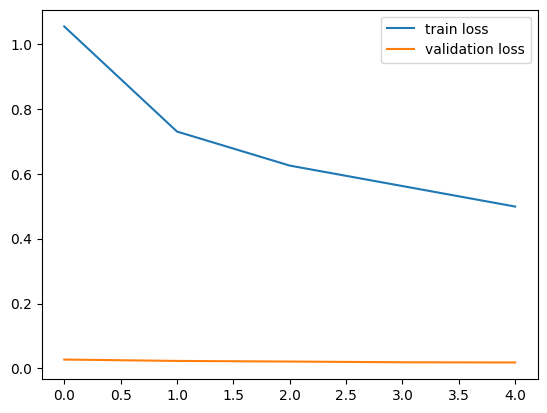

In [5]:

#train the model
#train(model, val_dataloader, val_dataloader, optimizer, criterion, 20)

train(model, train_dataloader, val_dataloader, optimizer, criterion, 5)